In [1]:
#importing all libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import yfinance as yf
%matplotlib inline
from keras.preprocessing.sequence import TimeseriesGenerator
import plotly.graph_objects as go



from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [2]:
# Historical Carnival Cruise Stock Price:
# OHLCV using yfinance
# Load the stocks data
ccl = yf.download("CCL", start="2016-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
ccl.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Historical Delta Airlines Stock Price:
# OHLCV using yfinance
# Load the stocks data
dal = yf.download("DAL", start="2016-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
dal.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Historical ETSY Stock Price:
# OHLCV using yfinance
# Load the stocks data
etsy = yf.download("ETSY", start="2016-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
etsy.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [5]:
# Historical L Brands Stock Price:
# OHLCV using yfinance
# Load the stocks data
pp = yf.download("PYPL", start="2016-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
pp.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [6]:
# Historical SPY Stock Price:
# OHLCV using yfinance
# Load the stocks data
spy = yf.download("SPY", start="2016-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
spy.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [7]:
#Copying dataframes
ccl_df = ccl[['Close']].copy()
dal_df = dal[['Close']].copy()
etsy_df = etsy[['Close']].copy()
pp_df = pp[['Close']].copy()
spy_df = spy[['Close']].copy()

In [8]:
#Creating a new dataframe and concatenating them all
ccl_df.rename(columns = {'Close':'CCL'}, inplace = True) 
dal_df.rename(columns = {'Close':'DAL'}, inplace = True) 
etsy_df.rename(columns = {'Close':'ETSY'}, inplace = True) 
pp_df.rename(columns = {'Close':'PYPL'}, inplace = True) 
spy_df.rename(columns = {'Close':'SPY'}, inplace = True) 
#spy_df.head()

In [9]:
#Creating a new dataframe with all the previous dfs
dfs = [ccl_df, dal_df, etsy_df, pp_df,spy_df ]
df = pd.concat(dfs,axis=1,join="outer",ignore_index=False)
df.tail()

,CCL,DAL,ETSY,PYPL,SPY
Date,,,,,
2021-01-13,20.100000,40.450001,207.029999,244.899994,379.790009
2021-01-14,20.920000,41.470001,211.520004,242.059998,378.459991
2021-01-15,20.790001,39.980000,204.419998,239.789993,375.700012
2021-01-19,20.870001,40.310001,221.309998,247.250000,378.649994
2021-01-20,20.780001,41.619999,215.690002,244.259995,383.890015


### Tree decision and Linear Regression prediction models

In [10]:
#Slicing the data to precovid times and creating a new dataframe
precovid_df = df['2016-01-01' :'2020-02-20']
precovid_df.tail()

,CCL,DAL,ETSY,PYPL,SPY
Date,,,,,
2020-02-13,43.200001,59.130001,52.970001,120.510002,337.059998
2020-02-14,42.599998,58.900002,53.160000,122.989998,337.600006
2020-02-18,42.919998,58.720001,53.320000,122.269997,336.730011
2020-02-19,43.340000,58.509998,53.180000,123.910004,338.339996
2020-02-20,42.500000,58.380001,54.389999,122.430000,336.950012


In [11]:
covid_df = df['2020-02-21' :'2021-01-21']
covid_df.head()

,CCL,DAL,ETSY,PYPL,SPY
Date,,,,,
2020-02-21,41.689999,57.869999,53.700001,119.489998,333.480011
2020-02-24,37.759998,54.230000,51.330002,116.440002,322.420013
2020-02-25,35.840000,50.889999,49.889999,109.660004,312.649994
2020-02-26,33.139999,49.590000,50.689999,109.110001,311.500000
2020-02-27,31.850000,48.189999,57.919998,107.839996,297.510010


In [12]:
#Checking on the shape of the data frame
precovid_df.shape

(1040, 5)

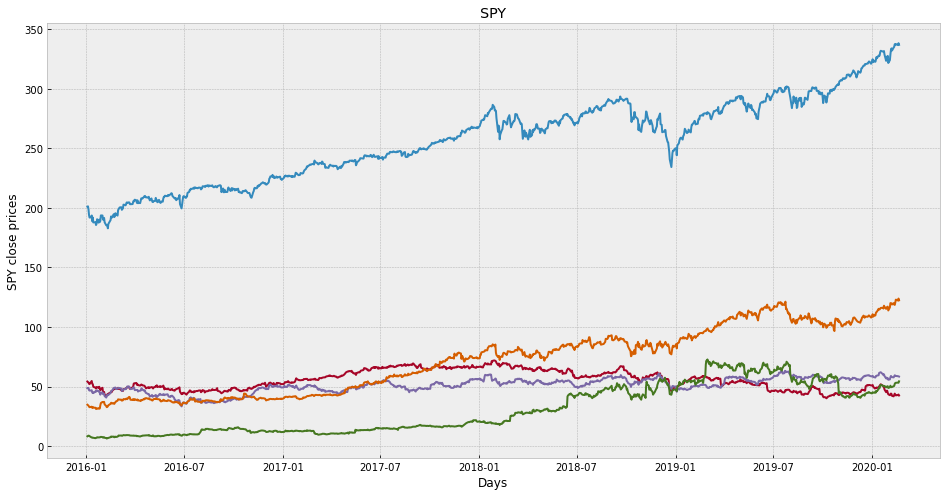

In [13]:
#Visualize the close price data
plt.figure(figsize=(16,8))
plt.title("SPY")
plt.xlabel('Days')
plt.ylabel("SPY close prices")
plt.plot(precovid_df['SPY']), plt.plot(precovid_df['CCL']), plt.plot(precovid_df['DAL']), plt.plot(precovid_df['ETSY']), plt.plot(precovid_df['PYPL'])
plt.show()

In [14]:
# Creating a variable to predict the 'x' days out into the future
future_days = 50
#Create a new column (target) shifted 'x' days up
precovid_df["Prediction"] = precovid_df[['SPY']].shift(-future_days)
precovid_df.tail()

,CCL,DAL,ETSY,PYPL,SPY,Prediction
Date,,,,,,
2020-02-13,43.200001,59.130001,52.970001,120.510002,337.059998,NaN
2020-02-14,42.599998,58.900002,53.160000,122.989998,337.600006,NaN
2020-02-18,42.919998,58.720001,53.320000,122.269997,336.730011,NaN
2020-02-19,43.340000,58.509998,53.180000,123.910004,338.339996,NaN
2020-02-20,42.500000,58.380001,54.389999,122.430000,336.950012,NaN


In [15]:
#Create a feature data set (x) and convert it to a numpy array and remove the last 'x' rows/days
X = np.array(precovid_df.drop(['Prediction', "CCL", "DAL", "ETSY", "PYPL"], 1))[:-future_days]
print(X)

[[201.02000427]
 [201.36000061]
 [198.82000732]
 [194.05000305]
 [191.91999817]
 [192.11000061]
 [193.66000366]
 [188.83000183]
 [191.92999268]
 [187.80999756]
 [188.05999756]
 [185.6499939 ]
 [186.69000244]
 [190.52000427]
 [187.63999939]
 [190.19999695]
 [188.13000488]
 [189.11000061]
 [193.72000122]
 [193.6499939 ]
 [190.16000366]
 [191.30000305]
 [191.6000061 ]
 [187.94999695]
 [185.41999817]
 [185.42999268]
 [185.27000427]
 [182.86000061]
 [186.63000488]
 [189.77999878]
 [192.88000488]
 [192.08999634]
 [192.        ]
 [194.77999878]
 [192.32000732]
 [193.19999695]
 [195.53999329]
 [195.08999634]
 [193.55999756]
 [198.11000061]
 [199.        ]
 [199.77999878]
 [200.42999268]
 [200.58999634]
 [198.3999939 ]
 [199.38000488]
 [199.53999329]
 [202.75999451]
 [202.5       ]
 [202.16999817]
 [203.33999634]
 [204.63000488]
 [204.38000488]
 [204.66999817]
 [204.55999756]
 [203.21000671]
 [203.11999512]
 [203.24000549]
 [205.11999512]
 [206.02000427]
 [205.52000427]
 [206.91999817]
 [206.25

In [16]:
#Create the target data set (y) and coverted to a numpy aaray and get all of the target values except the last "x" rows/days
y = np.array(precovid_df['Prediction'])[:-future_days]
print(y)

[203.33999634 204.63000488 204.38000488 204.66999817 204.55999756
 203.21000671 203.11999512 203.24000549 205.11999512 206.02000427
 205.52000427 206.91999817 206.25       204.19000244 206.41999817
 203.94999695 204.5        204.02000427 205.91999817 208.
 208.00999451 207.77999878 209.24000549 209.8999939  210.1000061
 208.97000122 208.97000122 208.61000061 208.91999817 209.3500061
 207.44999695 206.33000183 207.97000122 206.16000366 205.00999451
 204.97000122 205.72000122 205.88999939 208.44999695 206.5
 206.55999756 204.75999451 206.77999878 204.8500061  204.91000366
 204.19999695 205.49000549 205.21000671 207.86999512 209.27999878
 209.33999634 210.24000549 209.83999634 210.27000427 210.91000366
 210.27999878 211.3500061  211.67999268 212.36999512 212.08000183
 210.07000732 208.44999695 208.03999329 207.75       208.36999512
 206.52000427 207.8500061  208.44000244 208.1000061  210.80999756
 203.24000549 199.6000061  203.19999695 206.66000366 209.47999573
 209.91999817 208.41000366 

In [17]:
#Split the data into 75% training and 25% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [18]:
#Create the models 
#Create the decision tree regresor model
tree = DecisionTreeRegressor().fit(x_train, y_train)
lr = LinearRegression().fit(x_train, y_train)

In [19]:
#Get the last 'x' rows of the feature data set
x_future = precovid_df.drop(['Prediction', "CCL", "DAL", "ETSY", "PYPL"], 1) [:-future_days]
x_future = x_future.tail(future_days)
x_future = np.array(x_future)
x_future

array([[295.3999939 ],
       [296.76998901],
       [293.23999023],
       [288.05999756],
       [290.42001343],
       [294.3500061 ],
       [293.07998657],
       [288.52999878],
       [291.26998901],
       [293.23999023],
       [296.27999878],
       [295.95001221],
       [298.88000488],
       [298.3999939 ],
       [299.27999878],
       [297.97000122],
       [299.98999023],
       [299.01000977],
       [299.88000488],
       [300.36999512],
       [301.6000061 ],
       [303.29998779],
       [303.20999146],
       [304.14001465],
       [303.32998657],
       [306.14001465],
       [307.36999512],
       [307.02999878],
       [307.1000061 ],
       [308.17999268],
       [308.94000244],
       [308.3500061 ],
       [309.        ],
       [309.1000061 ],
       [309.54998779],
       [311.79000854],
       [312.01998901],
       [311.92999268],
       [310.76998901],
       [310.26998901],
       [310.95999146],
       [313.36999512],
       [314.07998657],
       [315

In [20]:
#Show the model tree prediction
tree_prediction = tree.predict(x_future)
print(tree_prediction)
print()
#Show the model linear regression prediction
lr_prediction = lr.predict(x_future)
print(lr_prediction)

[300.25       314.86999512 292.57998657 317.13000488 317.32000732
 319.5        292.57998657 319.58999634 320.8999939  292.57998657
 321.22000122 321.23001099 322.94000244 311.64001465 321.07998657
 321.85998535 324.86999512 322.94000244 323.64001465 310.76998901
 324.45001221 327.45001221 325.70999146 327.95001221 327.45001221
 328.19000244 330.92001343 331.95001221 331.29998779 331.33999634
 331.72000122 328.76998901 323.5        326.89001465 337.6000061
 337.05999756 321.73001099 321.73001099 333.98001099 333.98001099
 333.98001099 332.20001221 334.67999268 335.26000977 337.42001343
 337.05999756 337.6000061  336.73001099 321.73001099 336.95001221]

[300.6842687  301.99905812 298.61130515 293.64004689 295.9049629
 299.67659151 298.45774904 294.09110881 296.72068764 298.61130515
 301.52881267 301.21212333 304.02404821 303.56337988 304.40792384
 303.1507143  305.08930528 304.14881438 304.98375193 305.45399738
 306.63444351 308.26592226 308.17955244 309.07209917 308.2947122
 310.991506

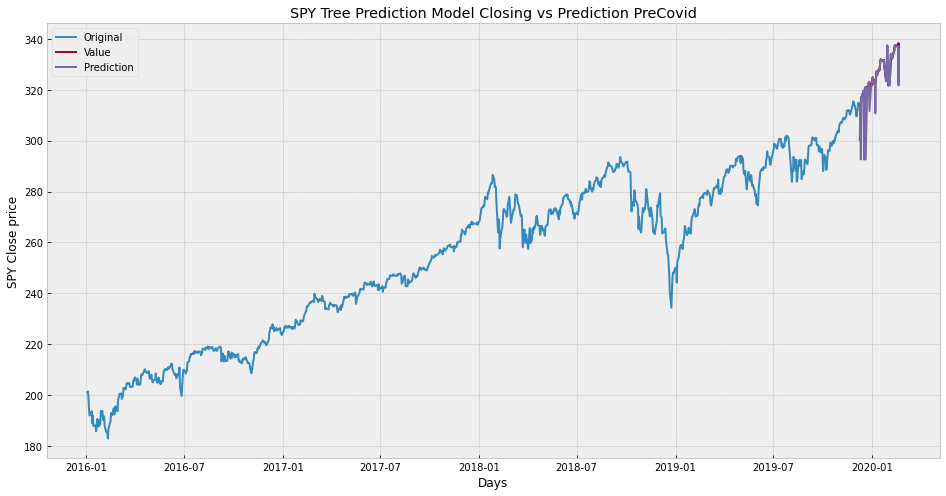

In [21]:
#Vizualize the data SPY Tree Prediction Model Closing vs Prediction PreCovid
predictions= tree_prediction

valid = precovid_df[X.shape[0]:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('SPY Tree Prediction Model Closing vs Prediction PreCovid')
plt.xlabel('Days')
plt.ylabel('SPY Close price')
plt.plot(precovid_df['SPY'])
plt.plot(valid[['SPY', 'Predictions']])
plt.legend(['Original', 'Value', 'Prediction'])
plt.show()

In [22]:
#Printing the data in a table
valid

,CCL,DAL,ETSY,PYPL,SPY,Prediction,Predictions
Date,,,,,,,
2019-12-09,45.410000,55.799999,41.160000,103.779999,313.880005,NaN,300.250000
2019-12-10,45.320000,55.529999,40.509998,103.620003,313.529999,NaN,314.869995
2019-12-11,45.790001,55.080002,41.029999,105.510002,314.420013,NaN,292.579987
2019-12-12,46.900002,56.689999,41.980000,105.669998,317.130005,NaN,317.130005
2019-12-13,47.450001,56.730000,42.290001,107.650002,317.320007,NaN,317.320007
2019-12-16,46.990002,58.419998,43.099998,109.570000,319.500000,NaN,319.500000
2019-12-17,47.200001,58.689999,43.049999,108.459999,319.570007,NaN,292.579987
2019-12-18,46.580002,58.580002,42.340000,107.830002,319.589996,NaN,319.589996
2019-12-19,46.650002,59.139999,43.939999,108.879997,320.899994,NaN,320.899994


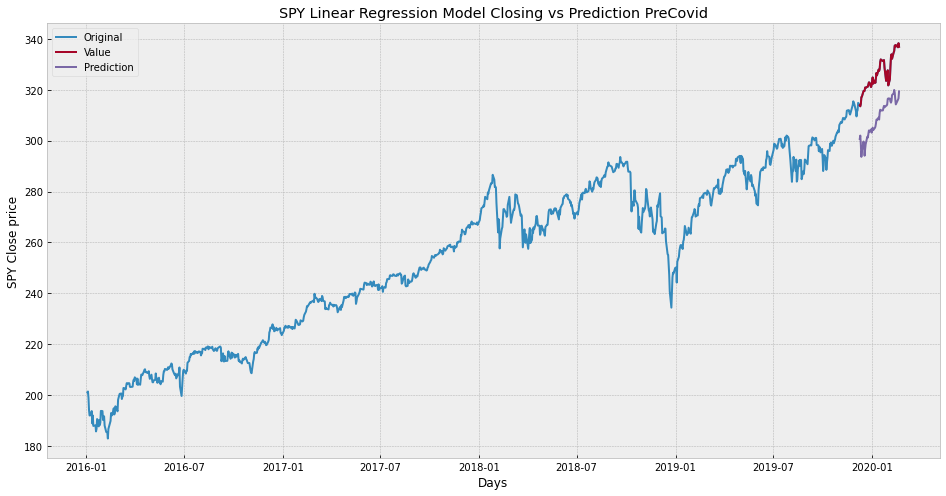

In [23]:
#Visualizing the data SPY Linear Regression Model Closing vs Prediction PreCovid
predictions= lr_prediction

valid = precovid_df[X.shape[0]:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('SPY Linear Regression Model Closing vs Prediction PreCovid')
plt.xlabel('Days')
plt.ylabel('SPY Close price')
plt.plot(precovid_df['SPY'])
plt.plot(valid[['SPY', 'Predictions']])
plt.legend(['Original', 'Value', 'Prediction'])
plt.show()

In [24]:
#Printing the data in a table
valid

,CCL,DAL,ETSY,PYPL,SPY,Prediction,Predictions
Date,,,,,,,
2019-12-09,45.410000,55.799999,41.160000,103.779999,313.880005,NaN,300.684269
2019-12-10,45.320000,55.529999,40.509998,103.620003,313.529999,NaN,301.999058
2019-12-11,45.790001,55.080002,41.029999,105.510002,314.420013,NaN,298.611305
2019-12-12,46.900002,56.689999,41.980000,105.669998,317.130005,NaN,293.640047
2019-12-13,47.450001,56.730000,42.290001,107.650002,317.320007,NaN,295.904963
2019-12-16,46.990002,58.419998,43.099998,109.570000,319.500000,NaN,299.676592
2019-12-17,47.200001,58.689999,43.049999,108.459999,319.570007,NaN,298.457749
2019-12-18,46.580002,58.580002,42.340000,107.830002,319.589996,NaN,294.091109
2019-12-19,46.650002,59.139999,43.939999,108.879997,320.899994,NaN,296.720688
